# Benchmark


In [ ]:
import numpy as np

from pepme.core import (
    FeatureCache,
    barplot,
    compute_metrics,
    show_table,
)
from pepme.embeddings.esm2 import ESM2
from pepme.metrics.fid import FID
from pepme.metrics.id import ID
from pepme.metrics.novelty import Novelty
from pepme.metrics.precision_recall import PrecisionRecall
from pepme.metrics.uniqueness import Uniqueness
from pepme.properties.gravy import Gravy
from pepme.utils import random_subset, read_fasta_file

Let's load the datasets.


In [ ]:
DATASET_PATHS = {
    "AMP-Diffusion": "../data/amp-diffusion.fasta",
    "AMP-GAN": "../data/amp-gan.fasta",
    "CPL-Diff": "../data/cpl-diff.fasta",
    "HydrAMP": "../data/hydramp.fasta",
    "OmegAMP": "../data/omegamp.fasta",
    "DBAASP": "../data/dbaasp.fasta",
    "UniProt": "../data/uniprot/uniprot_8_50_100.fasta",
}

In [ ]:
datasets = {name: read_fasta_file(path) for name, path in DATASET_PATHS.items()}

In [ ]:
for model_name, sequences in datasets.items():
    print(f"{model_name}: {len(sequences)} sequences")

AMP-Diffusion: 47671 sequences
AMP-GAN: 150000 sequences
CPL-Diff: 49985 sequences
HydrAMP: 50000 sequences
OmegAMP: 149504 sequences
DBAASP: 8967 sequences
UniProt: 2933310 sequences


In [ ]:
n_samples = 3_000
seed = 42

benchmark_datasets = {
    name: random_subset(sequences, n_samples=n_samples, seed=seed)
    if len(sequences) > n_samples
    else sequences
    for name, sequences in datasets.items()
}


def my_embedder(sequences: list[str]) -> np.ndarray:
    lengths = [len(sequence) for sequence in sequences]
    counts = [sequence.count("K") for sequence in sequences]
    return np.array([lengths, counts]).T


cache = FeatureCache(
    models={
        "embedder": my_embedder,
        "esm2": ESM2(
            model_name="esm2_t6_8M_UR50D",
            batch_size=256,
            device="cpu",
            verbose=False,
        ),
    }
)

Let's select the metrics.

In [ ]:
embedder = "esm2"  # "embedder"

metrics = [
    Novelty(reference=benchmark_datasets["DBAASP"], reference_name="DBAASP"),
    Uniqueness(),
    FID(
        reference=benchmark_datasets["DBAASP"],
        embedder=cache.model(embedder),
        reference_name="DBAASP",
    ),
    ID(Gravy(), name="Gravy", objective="minimize"),
    PrecisionRecall(
        metric="precision",
        neighborhood_size=3,
        reference=benchmark_datasets["DBAASP"],
        embedder=cache.model(embedder),
        strict=False,
    ),
    PrecisionRecall(
        metric="recall",
        neighborhood_size=3,
        reference=benchmark_datasets["DBAASP"],
        embedder=cache.model(embedder),
        strict=False,
    ),
]

In [ ]:
df = compute_metrics(benchmark_datasets, metrics)

100%|██████████| 42/42 [01:55<00:00,  2.74s/it, data=UniProt, metric=Recall]            


Let's look at the results.


In [ ]:
show_table(df, decimals=[4, 3, 1, 2, 3, 4])

,Novelty (DBAASP)↑,Uniqueness↑,FID (DBAASP)↓,Gravy↓,Precision↑,Recall↑
AMP-Diffusion,1.0000,0.973,1.1,-0.16±0.78,0.654,0.5207
AMP-GAN,0.9997,1.000,3.6,0.02±0.78,0.816,0.2523
CPL-Diff,0.9990,0.990,1.3,-0.16±1.20,0.697,0.7683
HydrAMP,1.0000,1.000,4.4,-0.41±1.00,0.555,0.4503
OmegAMP,0.9963,0.982,1.0,-0.30±0.99,0.811,0.7463
DBAASP,0.0000,0.995,0.0,-0.31±1.00,1.000,1.0000
UniProt,1.0000,1.000,3.6,-0.18±0.74,0.675,0.5210


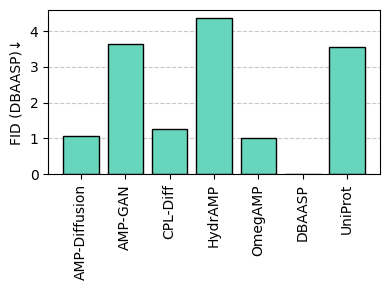

In [ ]:
barplot(df, "FID (DBAASP)", x_ticks_label_rotation=90)